In [5]:
#IMPORT LIBRARIES
import gymnasium as gym
from gym_anytrading.envs import TradingEnv, StocksEnv, Actions, Positions
from finta import TA

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import PPO 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [6]:
df = pd.read_csv(r'C:\Users\abhis\OneDrive\Desktop\FinRL\data\NVDA.csv')
df.head()
df.shape

(1258, 7)

In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [8]:
df.sort_values('Date', ascending=True, inplace=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-02-27,39.130001,39.397499,38.277500,38.852501,38.550713,50025600
1,2019-02-28,38.750000,38.974998,38.340000,38.564999,38.304893,32494400
2,2019-03-01,39.067501,39.537498,38.480000,39.112499,38.848686,35718800
3,2019-03-04,39.500000,39.730000,38.625000,39.195000,38.930634,40999200
4,2019-03-05,39.037498,39.514999,38.490002,39.130001,38.866074,36292400


In [9]:
df.set_index("Date", inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-02-27,39.130001,39.397499,38.277500,38.852501,38.550713,50025600
2019-02-28,38.750000,38.974998,38.340000,38.564999,38.304893,32494400
2019-03-01,39.067501,39.537498,38.480000,39.112499,38.848686,35718800
2019-03-04,39.500000,39.730000,38.625000,39.195000,38.930634,40999200
2019-03-05,39.037498,39.514999,38.490002,39.130001,38.866074,36292400


In [10]:
env = gym.make('stocks-v0', df=df, frame_bound=(20, 1000), window_size=20)

c:\Users\abhis\Anaconda3\envs\env\lib\site-packages\gymnasium\utils\passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (20, 2)
  logger.warn(


info: {'total_reward': 101.4499626159668, 'total_profit': 0.06411553633517264, 'position': <Positions.Short: 0>}


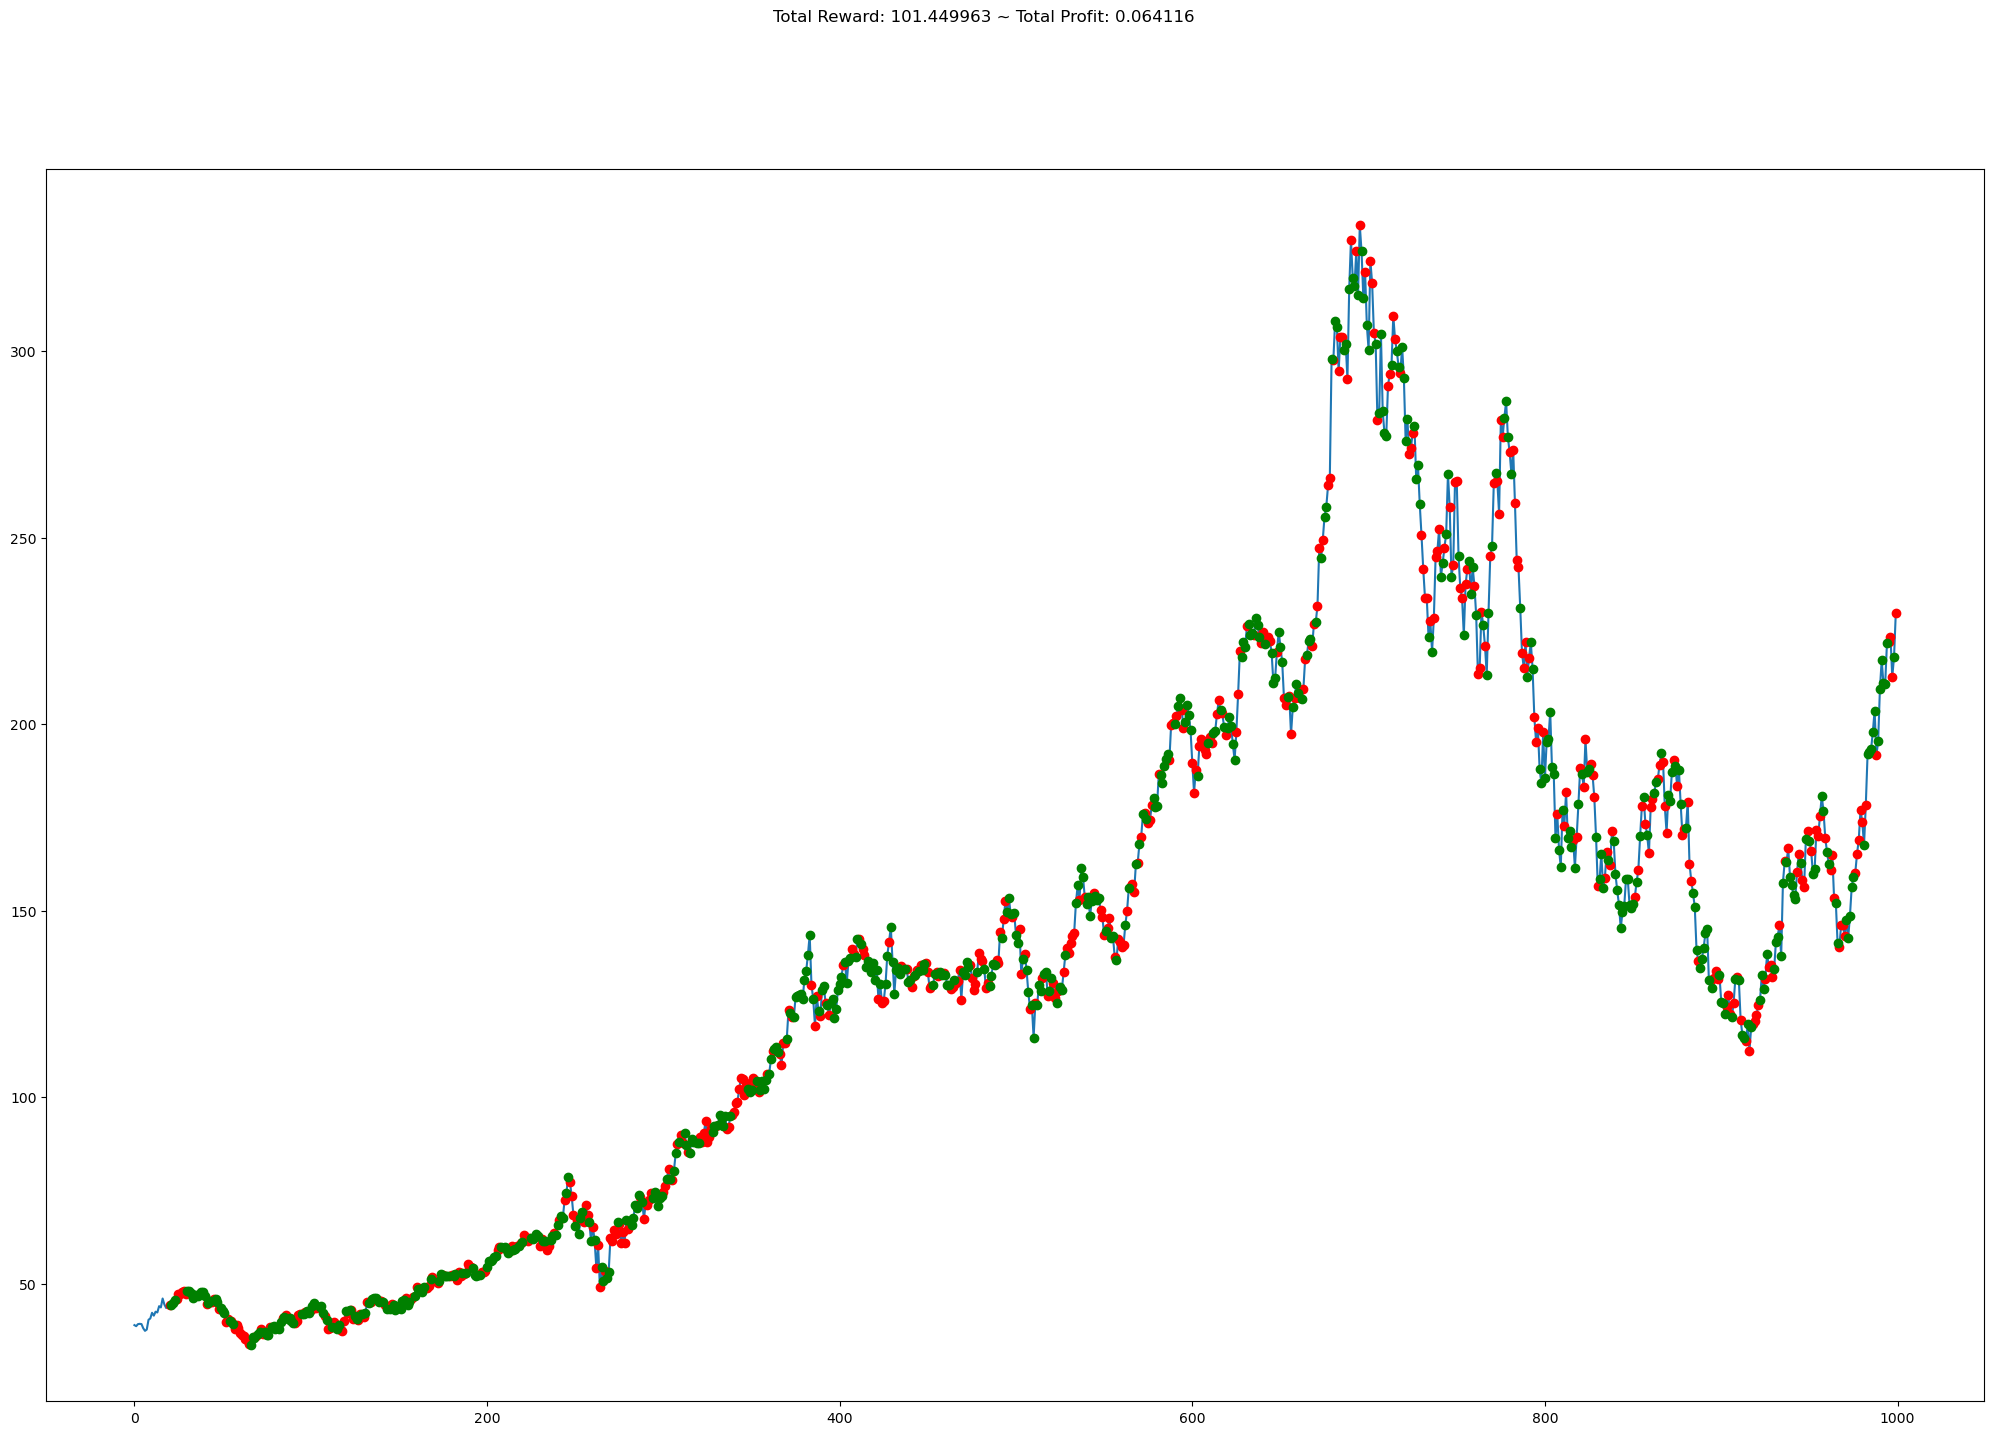

In [11]:
observation = env.reset()
while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        print("info:", info)
        break
plt.figure(figsize=(25, 16))
plt.cla()
env.unwrapped.render_all()
plt.show()

In [12]:
df['Volume'] = df['Volume'].astype(float)
df['SMA'] = TA.SMA(df, 20)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)

df.fillna(0, inplace=True)

def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Close', 'Volume', 'SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

In [13]:
class CustomTradingEnv(StocksEnv):
    _process_data = add_signals

#CREATE UPDATED STOCK ENV
env2 = CustomTradingEnv(df=df, window_size=12, frame_bound=(20, 1000))
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [14]:
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=250_000)

Using cuda device
-----------------------------
| time/              |      |
|    fps             | 367  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 359         |
|    iterations           | 2           |
|    time_elapsed         | 11          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009243051 |
|    clip_fraction        | 0.0135      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.688      |
|    explained_variance   | 0.00114     |
|    learning_rate        | 0.0003      |
|    loss                 | 52.3        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.000336   |
|    value_loss           | 99.5        |
-----------------------------------------
----------------

In [15]:
env = CustomTradingEnv(df=df, window_size=12, frame_bound=(1000, 1250))
obs, _ = env.reset()

while True:
    action, _states = model.predict(obs)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        print("info:", info)
        break

info: {'total_reward': 0.0, 'total_profit': 3.229237704070081, 'position': <Positions.Long: 1>}


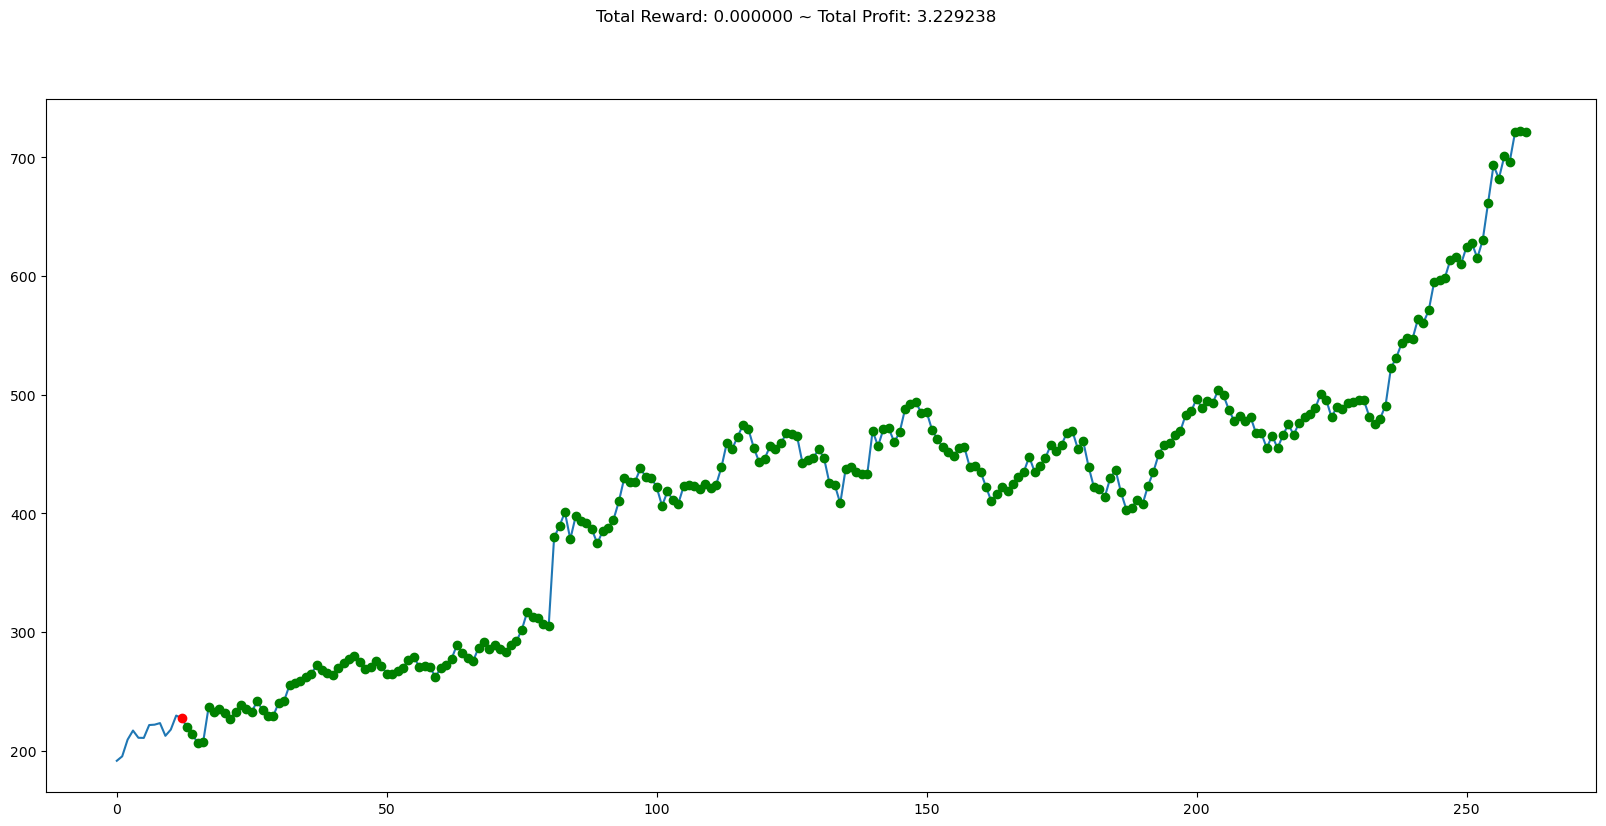

In [18]:
plt.figure(figsize=(20, 9))
plt.cla()
env.render_all()
plt.show()